# Nicolas DURAT - Advanced Databases for Finance Project Assignment

# Environment setup

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install psycopg2

In [7]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

# Problem statement

In order to have a clear view of the employment market in France, the ministry of economy, in a joint initiative with the “Pôle Emploi” institution, decided to create a database containing:

- The information about the people, the companies that employ them, the sector of activity of those companies, the departments where they are located and where the people live
- In addition, information about the regions to which the departments belong

# 1- Entity-Relation Diagram

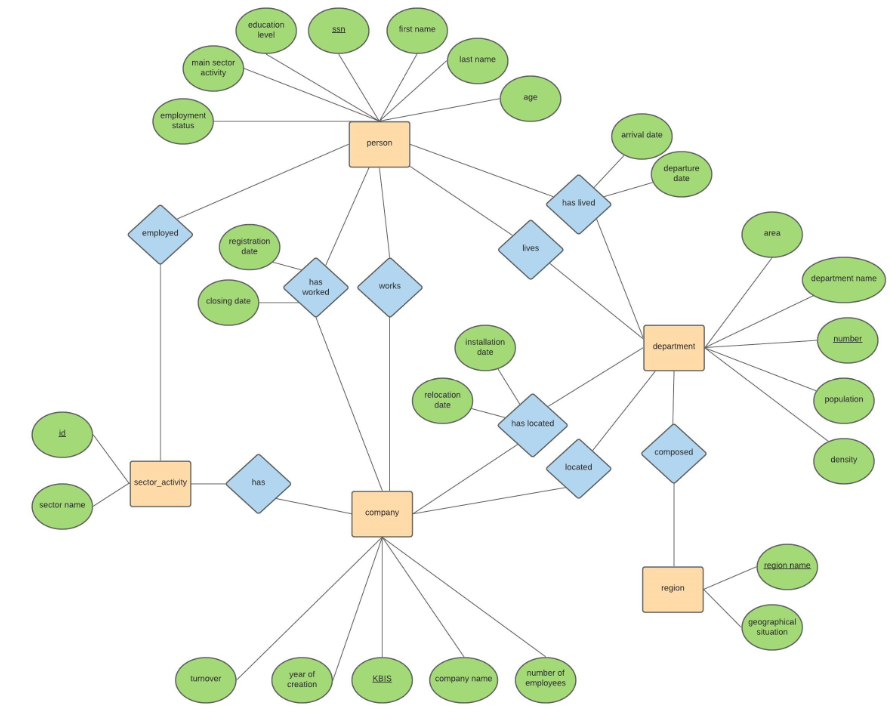

**Taking the words from the statement we get the ER Diagram above. The primary keys are underlined for each entity. We have 5 entities, 9 relations and 27 attributes in total. In order to have the history of the employment contracts of the employees, the moves of the people and the companies. I voluntarily added two relations (one for the history/one for the present) between person and company, between department and person and between company and department. The relation that allows to get the history contains two attributes (two dates: start/end).**

# 2- Relational schema

## MCD

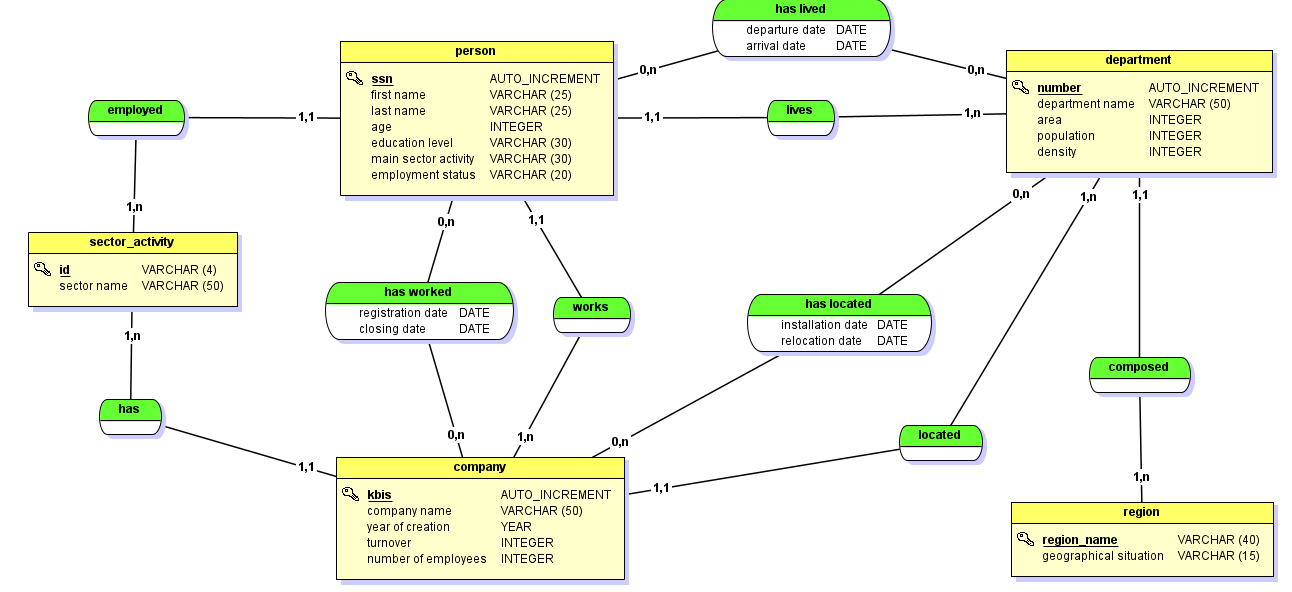

## MLD

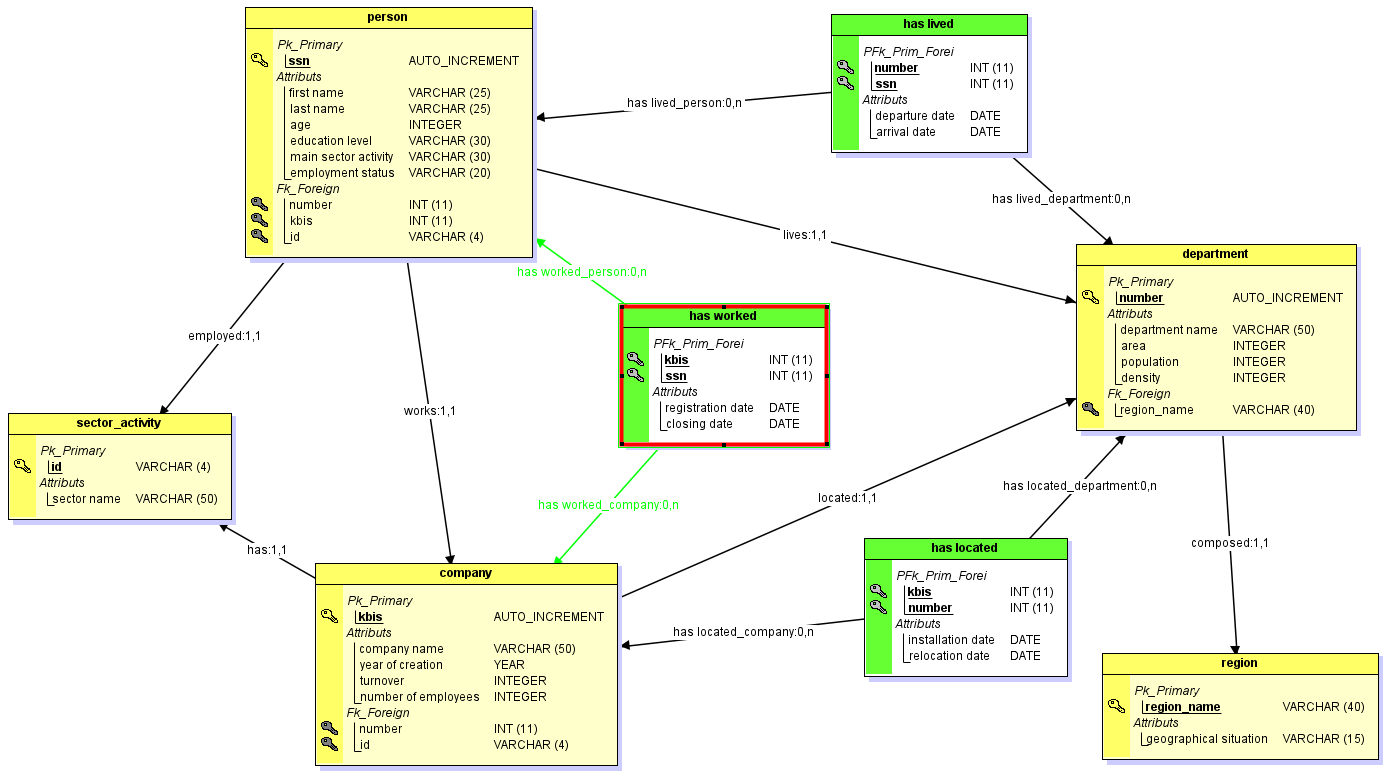

person(ssn: string(primary key), 
       first_name: string, 
       last_name: string,
       age: integer,
       education_level: string,
       main_sector_activity: string,
       employment_status: string,
       number: integer(foreign key(department)),
       kbis: integer(foreign key(company)),
       id: integer(foreign key(sector_activity)))

company(kbis: string(primary key), 
        company name: string,
        year_of_creation: integer,
        turnover: integer,
        number_of_employees: integer
        number: integer(foreign key(department)),
        id: integer(foreign key(sector_activity)))

sector_activity(id: string(primary key), 
                sector_name: string)
       
department(number: integer(primary key), 
           department_name: string, 
           area: integer,
           population: integer,
           density: integer,
           region_name: string(foreign key(region)))
       
region(region_name: string(primary key), 
       geographical_situation: string)

has_lived(number: integer(primary key), 
           ssn: integer(primary key),
           departure date: string,
           arrival date: string,
           number: integer(foreign key(department)), 
           ssn: integer(foreign key(person)))

has_worked(kbis: integer(primary key), 
           ssn: integer(primary key),
           registration date: string,
           closing date: string,
           kbis: integer(foreign key(company)), 
           ssn: integer(foreign key(person)))

has_located(kbis: integer(primary key), 
           number: integer(primary key),
           installation date: string,
           relocation date: string,
           kbis: integer(foreign key(company)), 
           number: integer(foreign key(department)))

**For this part I used JMerise to obtain the MCD, MLD and deduce the relational schema and the PostgreSQL code.**

# 3- Tables creation

In [196]:
# SQL Query

postgresql_query = ["""CREATE TABLE public.sector_activity(
                                id            VARCHAR (4) NOT NULL,
                                sector_name   VARCHAR (50),
                                CONSTRAINT sector_activity_PK PRIMARY KEY (id));""",


                    """CREATE TABLE public.region(
                                region_name              VARCHAR (40) NOT NULL,
                                geographical_situation   VARCHAR (15),
                                CONSTRAINT region_PK PRIMARY KEY (region_name));""",


                    """CREATE TABLE public.department(
                                number            INTEGER NOT NULL,
                                department_name   VARCHAR (50),
                                area              INTEGER,
                                population        INTEGER  NOT NULL,
                                density           INTEGER  NOT NULL,
                                region_name       VARCHAR (40) NOT NULL,
                                CONSTRAINT department_PK PRIMARY KEY (number),
                                CONSTRAINT department_region_FK FOREIGN KEY (region_name) REFERENCES public.region(region_name));""",

                    
                    """CREATE TABLE public.company(
                                kbis                  SERIAL NOT NULL,
                                company_name          VARCHAR (50),
                                year_of_creation      INTEGER,
                                turnover              INTEGER  NOT NULL,
                                number_of_employees   INTEGER  NOT NULL,
                                number                INT  NOT NULL,
                                id                    VARCHAR (4) NOT NULL,
                                CONSTRAINT company_PK PRIMARY KEY (kbis),
                                CONSTRAINT company_department_FK FOREIGN KEY (number) REFERENCES public.department(number),
                                CONSTRAINT company_sector_activity0_FK FOREIGN KEY (id) REFERENCES public.sector_activity(id));""",

                    
                    """CREATE TABLE public.person(
                                ssn                    SERIAL NOT NULL,
                                first_name             VARCHAR (25),
                                last_name              VARCHAR (25),
                                age                    INTEGER  NOT NULL,
                                education_level        VARCHAR (30) NOT NULL,
                                main_sector_activity   VARCHAR (30),
                                employment_status      VARCHAR (20) NOT NULL,
                                number                 INT  NOT NULL,
                                kbis                   INT,
                                id                     VARCHAR (4),
                                CONSTRAINT person_PK PRIMARY KEY (ssn),
                                CONSTRAINT person_department_FK FOREIGN KEY (number) REFERENCES public.department(number),
                                CONSTRAINT person_company0_FK FOREIGN KEY (kbis) REFERENCES public.company(kbis),
                                CONSTRAINT person_sector_activity1_FK FOREIGN KEY (id) REFERENCES public.sector_activity(id));""",


                    """CREATE TABLE public.has_located(
                                kbis                INT  NOT NULL,
                                number              INT  NOT NULL,
                                installation_date   DATE  NOT NULL,
                                relocation_date     DATE  NOT NULL,
                                CONSTRAINT has_located_PK PRIMARY KEY (kbis,number),
                                CONSTRAINT has_located_company_FK FOREIGN KEY (kbis) REFERENCES public.company(kbis),
                                CONSTRAINT has_located_department0_FK FOREIGN KEY (number) REFERENCES public.department(number));""",


                    """CREATE TABLE public.has_lived(
                                number           INT  NOT NULL,
                                ssn              INT  NOT NULL,
                                departure_date   DATE  NOT NULL,
                                arrival_date     DATE  NOT NULL,
                                CONSTRAINT has_lived_PK PRIMARY KEY (number,ssn),
                                CONSTRAINT has_lived_department_FK FOREIGN KEY (number) REFERENCES public.department(number),
                                CONSTRAINT has_lived_person0_FK FOREIGN KEY (ssn) REFERENCES public.person(ssn));""",


                    """CREATE TABLE public.has_worked(
                                kbis                INT  NOT NULL,
                                ssn                 INT  NOT NULL,
                                registration_date   DATE  NOT NULL,
                                closing_date        DATE  NOT NULL,
                                CONSTRAINT has_worked_PK PRIMARY KEY (kbis,ssn),
                                CONSTRAINT has_worked_company_FK FOREIGN KEY (kbis) REFERENCES public.company(kbis),
                                CONSTRAINT has_worked_person0_FK FOREIGN KEY (ssn) REFERENCES public.person(ssn));"""]

In [197]:
# Tables creation function

def tables_creation(postgresql_query : list):
    try :
        # Database connection 
        connection = psycopg2.connect(database='pe_bdd', user='postgres', password='KW6MNmP3')
        
        # Allows Python code to execute PostgreSQL command in a database session.
        cursor = connection.cursor()
        
        # Create table one by one
        for index, queries in enumerate(postgresql_query):
            cursor.execute(queries)
            names = ' '.join(queries.split('.'))
            names = ' '.join(names.split('('))
            names = names.split(' ')
            print("Table n°{0} : {1} creates...".format(index+1, names[3]))
        
        print()
        
        # Commit the changes
        connection.commit()
        print("Changes committed.")
        
    except(Exception, psycopg2.DatabaseError) as error:
        print("Tables creation failure :", error)
        # Return to the last commit 
        connection.rollback()
        
    finally:
    # Closing database connection
        if connection:
            cursor.close()
            connection.close()
            print("Database connection is closed.")

In [198]:
tables_creation(postgresql_query)

Table n°1 : sector_activity creates...
Table n°2 : region creates...
Table n°3 : department creates...
Table n°4 : company creates...
Table n°5 : person creates...
Table n°6 : has_located creates...
Table n°7 : has_lived creates...
Table n°8 : has_worked creates...

Changes committed.
Database connection is closed.


**The objective of this part is to get the JMerise postgreSQL code and to put it in a list. Then a function that takes in parameter this list is created in order to execute the queries and display in real time the creation of the tables. The structure of the function is built in such a way as to always frame the operations on the database and to anticipate errors.**

# 4- Data creation

In [199]:
# SQL Queries for insertion

postgresql_insert = ["""INSERT INTO sector_activity(id, sector_name) VALUES(%s, %s);""",
                     """INSERT INTO region(region_name, geographical_situation) VALUES(%s, %s);""",
                     """INSERT INTO department(number, department_name, area, population, density, region_name) VALUES(%s, %s, %s, %s, %s, %s);""",
                     """INSERT INTO company(kbis, company_name, year_of_creation, turnover, number_of_employees, number, id) VALUES(%s, %s, %s, %s, %s, %s, %s);""",
                     """INSERT INTO person(ssn, first_name, last_name, age, education_level, main_sector_activity, employment_status, number, kbis, id) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s);""",
                     """INSERT INTO has_located(kbis, number, installation_date, relocation_date) VALUES(%s, %s, %s, %s);""",
                     """INSERT INTO has_lived(number, ssn, departure_date, arrival_date) VALUES(%s, %s, %s, %s);""",
                     """INSERT INTO has_worked(kbis, ssn, registration_date, closing_date) VALUES(%s, %s, %s, %s);"""]

In [200]:
# Values for completation

sector_activity = [("aero", "aeronautics"), ("fina", "finance"), ("luxe", "luxury"), ("spac", "aerospace"), ("medi", "medical"), 
          ("jwlr", "jewelry"), ("trsm", "tourism"), ("mktg", "marketing"), ("farm", "farming"), ("cptg", "computing")]

region = [("Bretagne", "West"), ("Grand-Est", "East"), ("Occitanie", "South"), ("Nouvelle Aquitaine", "West"), ("PACA", "South"), 
          ("Hauts-de-France", "North"), ("Auvergne-Rhône-Alpes", "East"), ("Normandie", "North"), ("Bourgogne-Franche-Comté", "East"), ("Ile-de-France", "North")]

department = [(75, "Paris", 10000, 1000000, 52, "Ile-de-France"), (86, "Vienne", 8000, 560000, 452, "Nouvelle Aquitaine"), (14, "Calvados", 48000, 16000, 758, "Normandie"), 
              (59, "Nord", 26541, 78945, 456, "Hauts-de-France"), (56, "Morbihan", 36987, 75329, 123, "Bretagne"), (39, "Jura", 4214, 98456, 852, "Bourgogne-Franche-Comté"), 
              (15, "Cantal", 4569, 7892, 4125, "Auvergne-Rhône-Alpes"), (57, "Moselle", 4263, 96321, 741, "Grand-Est"), (83, "Var", 75142, 4562, 9632, "PACA"), 
              (46, "Lot", 2654, 9384, 12, "Occitanie")]

company = [(1, "Kalina", 2006, 100000, 451263, 75, "aero"), (2, "Oufga", 1998, 4500000, 78956, 86, "fina"), (3, "Chillip", 2003, 6953214, 45126, 59, "cptg"), (4, "Dolci", 2009, 145823, 413, 75, "aero"), 
           (5, "Raca", 2017, 754126, 45639, 75, "aero"), (6, "Deza", 2011, 96354, 96541, 59, "medi"), (7, "Frevo", 2009, 741526, 74512, 59, "trsm"), (8, "Grinj", 2004, 635241, 95124, 75, "fina"), 
           (9, "Polmo", 2002, 741526, 63254, 39, "mktg"), (10, "Algos", 1996, 852416, 7895, 57, "farm")]

person = [(1, "patrick", "luron", 28 , "Master", "Engineer", "employed", 75, 1, "aero"), (2, "louis", "augustin", 45, "Master", "Engineer", "employed", 75, 4, "aero"), 
          (3, "stephane", "dubois", 29, "Doctorate", "Researcher", "employed", 86, 2, "fina"), (4, "bertrand", "refi", 47, "Bachelor", "Technician", "employed", 59, 7, "trsm"), 
          (5, "ludivine", "okolo", 32, "Bachelor", "Technician", "employed", 75, 5, "aero"), (6, "olivier", "mentrig", 35, "Master", None, "unemployed", 59, None, None), 
          (7, "benoit", "sadul", 41, "Master", "Engineer", "employed", 75, 1, "aero"), (8, "elie", "mezt", 54, "Master", None, "unemployed", 46, None, None), 
          (9, "armand", "lelop", 36, "Doctorate", "Researcher", "employed", 39, 9, "mktg"), (10, "jeanne", "pinu", 46, "Professional qualification", "Maintenance agent", "employed", 57, 10, "farm"),
          (11, "mathis", "molger", 39, "Master", None, "unemployed", 15, None, None), (12, "yvan", "leler", 51, "Doctorat", None, "unemployed", 15, None, None), (13, "louise", "agatha", 33, "Bachelor", None, "unemployed", 75, None, None)]

has_located = [(1, 15, '01-01-2006', '01-01-2009'), (1, 46, '02-01-2009', '01-01-2012'), (9, 57, '01-01-2002', '01-01-2012'), (9, 83, '02-01-2012', '01-01-2015'), (10, 14, '01-01-1996', '01-01-2006'), 
          (10, 86, '02-01-2006', '01-01-2008'), (6, 56, '01-01-2011', '01-01-2014'), (6, 75, '02-01-2014', '01-01-2018'), (8, 56, '01-01-2004', '01-01-2006'), (8, 39, '02-01-2006', '01-01-2019')]

has_lived = [(46, 10, '01-01-2009', '01-01-2006'), (15, 4, '01-01-2012', '02-01-2009'), (57, 6, '01-01-2012', '01-01-2002'), (83, 4, '01-01-2015', '02-01-2012'), (39, 8, '01-01-2019', '02-01-2006'), 
          (56, 11, '01-01-2006', '01-01-2004'), (56, 12, '01-01-2014', '01-01-2011'), (75, 9, '01-01-2018', '02-01-2014'), (56, 4, '01-01-2006', '01-01-2004'), (39, 13, '01-01-2019', '02-01-2006')]

has_worked = [(1, 10, '01-01-2006', '01-01-2009'), (1, 4, '02-01-2009', '01-01-2012'), (9, 6, '01-01-2002', '01-01-2012'), (9, 4, '02-01-2012', '01-01-2015'), (8, 11, '01-01-2004', '01-01-2006'), 
          (10, 8, '02-01-2006', '01-01-2019'), (6, 12, '01-01-2011', '01-01-2014'), (6, 9, '02-01-2014', '01-01-2018'), (8, 4, '01-01-2004', '01-01-2006'), (8, 13, '02-01-2006', '01-01-2019')]

In [206]:
# Recording of tuples

records = [sector_activity, region, department, company, person, has_located, has_lived, has_worked]

In [207]:
# Data insertion function

def data_insertion(postgresql_insert : list, records : list):
    try :
        # Database connection 
        connection = psycopg2.connect(database='pe_bdd', user='postgres', password='KW6MNmP3')
        
        # Allows Python code to execute PostgreSQL command in a database session.
        cursor = connection.cursor()
        
        # Execute many queries
        for index_queries, queries in enumerate(postgresql_insert):
            for index_values, values in enumerate(records):
                if index_queries == index_values:
                    cursor.executemany(queries, values)
                    names = ' '.join(queries.split(' '))
                    names = ' '.join(names.split('('))
                    names = names.split(' ')
                    print("Table n°{0} : {1} insertion...".format(index_queries+1, names[2]))
        
        print()
        
        
        # Get the number of inserted records
        print(cursor.rowcount, "records inserted successfully into each table.")
        
        # Commit the changes
        connection.commit()
        print("Changes committed.")
        
    except(Exception, psycopg2.DatabaseError) as error:
        print("Data insertion failure :", error)
        # Return to the last commit 
        connection.rollback()
        
    finally:
    # Closing database connection
        if connection:
            cursor.close()
            connection.close()
            print("Database connection is closed.")

In [208]:
data_insertion(postgresql_insert, records)

Table n°1 : sector_activity insertion...
Table n°2 : region insertion...
Table n°3 : department insertion...
Table n°4 : company insertion...
Table n°5 : person insertion...
Table n°6 : has_located insertion...
Table n°7 : has_lived insertion...
Table n°8 : has_worked insertion...

-1 records inserted successfully into each table.
Changes committed.
Database connection is closed.


**The objective of this part is to insert data into the database. To do this I put all my queries in a list and all my values are stored in variables which are themselves stored in a list. Then I made a function that takes in parameter these two lists (useful when there are several queries). The function performs an 'executemany' for the queries and values having the same indexes during the iteration. It also outputs the number of rows produced and displays the insertion in real time. The structure of the function is built in such a way as to always frame the operations on the database and to anticipate errors.**

# 5- Insights

In [407]:
# Data retrieve function

def data_retrieve(postgresql_query : str):
    try :
        # Database connection 
        connection = psycopg2.connect(database='pe_bdd', user='postgres', password='KW6MNmP3')
        
        # Allows Python code to execute PostgreSQL command in a database session.
        cursor = connection.cursor()
        
        # Retrieve several data from the same search
        cursor.execute(postgresql_query)

        if postgresql_query == postgresql_query1 :
            
            for row in cursor:
                print('There are {0} companies in the department {1}.'.format(row[0], row[1]))
                
        elif postgresql_query == postgresql_query2 :
            
            for row in cursor:
                    print('In the sector {0} there are {1} companies.'.format(row[0], row[1]))
        
        elif postgresql_query == postgresql_query3 :
            
            for row in cursor:
                for value in row:
                    print('{} person(s) have a master\'s degree and are unemployed at the same time.'.format(value))
                
        elif postgresql_query == postgresql_query4 :
            
            for row in cursor:
                print('There are {0} companies located in {1} ({2}).'.format(row[2], row[0], row[1]))
        
        else:
            
            for row in cursor:
                print('The department is {0} ({1}) with {2} person(s).'.format(row[1], row[2], row[0]))
        
        print()
        
        # Commit the changes
        connection.commit()
        print("Changes committed.")
        
    except(Exception, psycopg2.DatabaseError) as error:
        print("Data retrieve failure :", error)
        # Return to the last commit 
        connection.rollback()
        
    finally:
    # Closing database connection
        if connection:
            cursor.close()
            connection.close()
            print("Database connection is closed.")
    

How many companies there is in a specific department (choose one department, let’s say department number 75) ?

In [414]:
postgresql_query1 = """SELECT COUNT(company_name), department.number
                       FROM company 
                       INNER JOIN department ON company.number = department.number 
                       WHERE department.number = 75
                       GROUP BY department.number;"""

In [415]:
 data_retrieve(postgresql_query1)

There are 4 companies in the department 75.

Changes committed.
Database connection is closed.


Get the number of companies present in each sector activity ?

In [388]:
postgresql_query2 = """SELECT sector_activity.sector_name, COUNT(company_name) AS companies_number
                       FROM company 
                       INNER JOIN sector_activity ON company.id = sector_activity.id 
                       GROUP BY sector_activity.id
                       ORDER BY companies_number DESC;"""

In [389]:
data_retrieve(postgresql_query2)

In the sector aeronautics there are 3 companies.
In the sector finance there are 2 companies.
In the sector marketing there are 1 companies.
In the sector computing there are 1 companies.
In the sector medical there are 1 companies.
In the sector tourism there are 1 companies.
In the sector farming there are 1 companies.

Changes committed.
Database connection is closed.


How many people hold a master degree and are in same time unemployed ?

In [382]:
postgresql_query3 = """SELECT COUNT(ssn) 
                       FROM person 
                       WHERE education_level = 'Master' AND employment_status = 'unemployed';"""

In [383]:
data_retrieve(postgresql_query3)

3 person(s) have a master's degree and are unemployed at the same time.

Changes committed.
Database connection is closed.


Get the regions name and geographical situation and order them by the number of  companies situated in them, from the region with the greatest number of companies to the region with the least number ?

In [384]:
postgresql_query4 = """SELECT region.region_name, region.geographical_situation, COUNT(company.kbis) AS companies_number
                       FROM region 
                       INNER JOIN department ON department.region_name = region.region_name 
                       INNER JOIN company ON company.number = department.number 
                       GROUP BY region.region_name, region.geographical_situation 
                       ORDER BY companies_number DESC;"""

In [385]:
data_retrieve(postgresql_query4)

There are 4 companies located in Ile-de-France (North).
There are 3 companies located in Hauts-de-France (North).
There are 1 companies located in Bourgogne-Franche-Comté (East).
There are 1 companies located in Nouvelle Aquitaine (West).
There are 1 companies located in Grand-Est (East).

Changes committed.
Database connection is closed.


What is the department with the highest number of people having a bachelor or a master  and working in a company created after 2000 and operating in the activity sector 
“aeronautics” ?

In [416]:
postgresql_query5 = """SELECT COUNT(ssn) AS people_number, department.department_name, department.number
                       FROM department 
                       INNER JOIN person ON department.number = person.number 
                       INNER JOIN company ON company.kbis = person.kbis
                       INNER JOIN sector_activity ON company.id = sector_activity.id 
                       WHERE (person.education_level = 'Master' OR person.education_level = 'Bachelor') AND person.employment_status = 'employed' AND company.year_of_creation > 2000 AND sector_activity.sector_name = 'aeronautics' 
                       GROUP BY department.department_name, department.number;"""


In [417]:
data_retrieve(postgresql_query5)

The department is Paris (75) with 4 person(s).

Changes committed.
Database connection is closed.


**In this part, I started by making a function that allows me to execute my queries. Depending on the input queries a custom message will be displayed at the output. The structure of the function is built in such a way as to always frame the operations on the database and to anticipate errors. Finally, I run each query within the function.**